# **Deteksi Outlier dengan K-Nearest Neighbors (KNN) dalam Data Understanding**

## Apa itu Outlier?

Outlier adalah data yang sangat berbeda dari data lainnya dalam sebuah dataset. Outlier bisa muncul karena kesalahan pengukuran, variasi alami, atau fenomena yang memang tidak biasa. Dalam analisis data, penting untuk mengidentifikasi outlier karena mereka dapat mempengaruhi hasil analisis.

## Algoritma K-Nearest Neighbors (KNN)

KNN adalah algoritma sederhana namun kuat yang dapat digunakan untuk klasifikasi, regresi, dan deteksi outlier. Prinsip dasarnya adalah:

1. Untuk setiap titik data, cari K tetangga terdekat (berdasarkan jarak)
2. Gunakan informasi dari tetangga tersebut untuk membuat keputusan

## Deteksi Outlier dengan KNN
Untuk deteksi outlier, KNN bekerja dengan prinsip:

- Outlier cenderung berada jauh dari tetangga terdekatnya
- Jarak rata-rata ke K tetangga terdekat dapat digunakan sebagai skor anomali
- Titik data dengan skor anomali tinggi dianggap sebagai outlier

## Langkah Langkah Deteksi Outlier dengan KNN

 a. Menentukan Jarak Antar Titik Data  
Kita menggunakan metrik jarak seperti Euclidean Distance, Manhattan Distance, atau Minkowski Distance untuk mengukur jarak antara suatu titik dengan tetangga terdekatnya.  

 b. Menentukan K (Jumlah Tetangga Terdekat)  
Nilai K yang dipilih akan menentukan seberapa banyak tetangga yang dipertimbangkan.  
- Jika K terlalu kecil, model bisa terlalu sensitif terhadap noise.  
- Jika K terlalu besar, outlier bisa terdeteksi secara kurang akurat.  

c. Menghitung Skor Kepadatan (Density Score)  
Ada beberapa pendekatan untuk mengukur apakah suatu titik adalah outlier:  
1. K-Nearest Neighbor Distance  
   - Menghitung jarak rata-rata ke K tetangga terdekat. Jika jarak rata-rata terlalu besar, titik tersebut dianggap sebagai outlier.  
2. Local Outlier Factor (LOF)  
   - LOF membandingkan kepadatan lokal suatu titik dengan kepadatan lokal tetangganya. Jika kepadatan lokal suatu titik lebih kecil dibandingkan dengan tetangganya, maka titik tersebut dianggap sebagai outlier.  
3. Distance-Based Outlier Score  
   - Jika sebuah titik memiliki jumlah tetangga yang sangat sedikit dalam radius tertentu, maka kemungkinan besar titik tersebut adalah outlier.


## Kesimpulan
Deteksi outlier dengan KNN adalah metode yang efektif dan intuitif untuk mengidentifikasi data yang tidak biasa dalam dataset. Metode ini bekerja dengan menghitung jarak rata-rata ke K tetangga terdekat dan menggunakan nilai ini sebagai skor anomali.



In [1]:
%pip install pymysql
%pip install psycopg2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.3 MB/s eta 0:00:00


Kode diatas digunakan untuk menginstal dua pustaka Python, yaitu `pymysql` dan `psycopg2`, yang berfungsi sebagai konektor untuk basis data (database). Pustaka `pymysql` digunakan untuk menghubungkan aplikasi Python dengan database MySQL atau MariaDB menggunakan protokol MySQL asli. Sementara itu, `psycopg2` merupakan pustaka yang digunakan untuk menghubungkan Python dengan database PostgreSQL, menyediakan antarmuka yang efisien untuk menjalankan perintah SQL dan berinteraksi dengan database tersebut. Kedua perintah ini menggunakan **magic command** `%pip`, yang umumnya digunakan dalam lingkungan Jupyter Notebook untuk memastikan bahwa paket yang diperlukan diinstal dalam kernel yang sedang berjalan.

 id           class  petal_length  petal_width  sepal_length  sepal_width  knn_distance  outlier_knn
  1     Iris-setosa          14.0          2.0          20.0         15.0     21.809631        False
  3     Iris-setosa          13.0          2.0          19.0         22.0     25.365922        False
  4     Iris-setosa          15.0          2.0          23.0         24.0     29.824822        False
  5     Iris-setosa          14.0          2.0          17.0         25.0     27.182715        False
  6     Iris-setosa           1.7          0.4           5.4          3.9      3.674235        False
  7     Iris-setosa           1.4          0.3           4.6          3.4      4.102438        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      3.935734        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      4.207137        False
 10     Iris-setosa           1.5          0.1           4.9          3.1      3.968627    

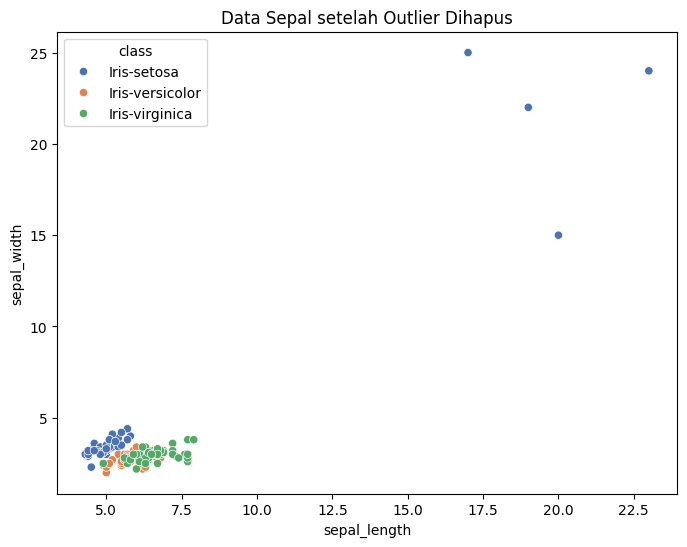

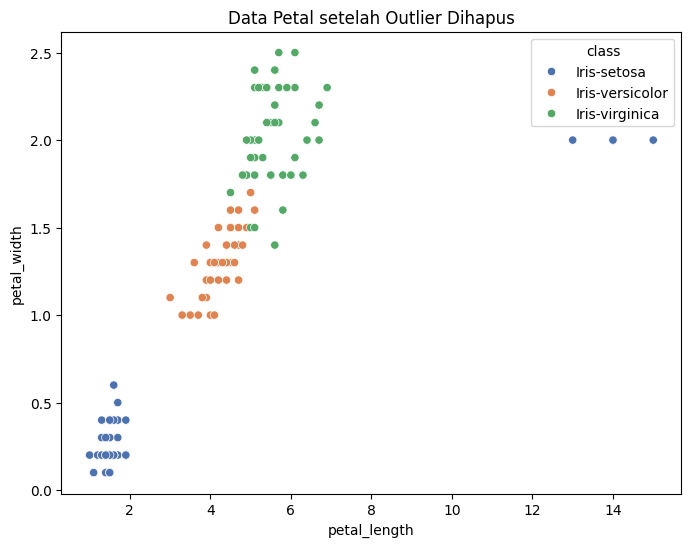

In [2]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-3d9a1619-abdillahfikrulazhari-be31.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_mSKvdrH9xCsL8Cs8TAP",
        database="defaultdb",
        port=10201
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_postgresql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-1790848a-abdillahfikrulazhari-be31.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_yeZaBHu3-BtJnqexe9A",
        database="iris_mysql",
        port=10201
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merged[feature_columns].values

# KNN Outlier Detection
def knn_outlier_detection(data, k=90):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=90)

# Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# Hapus data outlier
df_filtered = df_merged[~df_merged["outlier_knn"]]

# Cetak hasil setelah outlier dihapus
print(df_filtered.to_string(index=False))
print(f"\nJumlah data setelah outlier dihapus: {len(df_filtered)}")

# Visualisasi setelah outlier dihapus
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["sepal_length"], y=df_filtered["sepal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Sepal setelah Outlier Dihapus")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["petal_length"], y=df_filtered["petal_width"],
    hue=df_filtered["class"], palette="deep"
)
plt.title("Data Petal setelah Outlier Dihapus")
plt.show()

## **Memisahkan outlier dari data**

In [3]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-3d9a1619-abdillahfikrulazhari-be31.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_mSKvdrH9xCsL8Cs8TAP",
        database="defaultdb",
        port=10201
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_postgresql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-1790848a-abdillahfikrulazhari-be31.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_yeZaBHu3-BtJnqexe9A",
        database="iris_mysql",
        port=10201
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Ambil nama kolom
    cursor.close()
    conn.close()

    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'class'
df_merge = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik tanpa kolom 'class'
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merge[feature_columns].values

# Inisialisasi model LOF
clf = LocalOutlierFactor(n_neighbors=90)
label = clf.fit_predict(data_values)

# Tambahkan hasil label ke dataframe
df_merge["outlier_label"] = label

# Cetak hasil dengan ID dan class
print(df_merge.to_string(index=False))

num_outliers = (label == -1).sum()
print(f"\nJumlah outlier: {num_outliers}")
df_filtered = df_merge[label == 1].drop(columns=["outlier_label"], errors='ignore')
outliers = df_merge[label == -1].drop(columns=["outlier_label"], errors='ignore')
print("\nData Outlier:")
print(outliers.to_string(index=False))
print("\nJumlah data setelah dihapus : ",len(df_filtered))
print("\nData tidak outlier :")
print(df_filtered.to_string(index=False))

 id           class  petal_length  petal_width  sepal_length  sepal_width  outlier_label
  1     Iris-setosa          14.0          2.0          20.0         15.0             -1
  2     Iris-setosa          14.0          2.0          40.9         30.0             -1
  3     Iris-setosa          13.0          2.0          19.0         22.0             -1
  4     Iris-setosa          15.0          2.0          23.0         24.0             -1
  5     Iris-setosa          14.0          2.0          17.0         25.0             -1
  6     Iris-setosa           1.7          0.4           5.4          3.9              1
  7     Iris-setosa           1.4          0.3           4.6          3.4              1
  8     Iris-setosa           1.5          0.2           5.0          3.4              1
  9     Iris-setosa           1.4          0.2           4.4          2.9              1
 10     Iris-setosa           1.5          0.1           4.9          3.1              1
 11     Iris-setosa  

Kode di atas bertujuan untuk mendeteksi dan memisahkan outlier dari dataset yang diambil dari dua sumber basis data, yaitu PostgreSQL dan MySQL. Proses diawali dengan melakukan koneksi ke kedua basis data menggunakan pustaka psycopg2 untuk PostgreSQL dan pymysql untuk MySQL, lalu mengeksekusi query untuk mengambil seluruh data dari tabel "iris_postgresql" dan "irismysql". Data yang diperoleh kemudian dikonversi menjadi DataFrame menggunakan pandas, dan kedua dataset digabungkan berdasarkan kolom "id" dan "class" dengan metode inner join, sehingga hanya data yang terdapat di kedua tabel yang akan dipertahankan. Selanjutnya, hanya fitur numerik yang digunakan sebagai masukan untuk model deteksi outlier, yaitu "petal_length", "petal_width", "sepal_length", dan "sepal_width". Model Local Outlier Factor (LOF) dari scikit-learn kemudian diterapkan dengan parameter n_neighbors=90, yang berarti setiap titik data dibandingkan dengan 90 tetangga terdekatnya untuk menentukan apakah titik tersebut merupakan outlier atau bukan. LOF akan memberikan label 1 untuk data yang dianggap normal dan -1 untuk data yang terdeteksi sebagai outlier. Setelah model LOF diterapkan, hasil label outlier ditambahkan ke dalam DataFrame dengan nama kolom "outlier_label", kemudian jumlah total outlier dihitung berdasarkan banyaknya data yang memiliki label -1. Dataset kemudian dibagi menjadi dua bagian, yaitu data normal (tidak outlier) yang memiliki label 1 dan disimpan dalam variabel df_filtered, serta data outlier yang memiliki label -1 dan disimpan dalam variabel outliers. Hasil deteksi outlier kemudian dicetak dengan menampilkan seluruh dataset yang telah diberi label outlier, jumlah total data yang dikategorikan sebagai outlier, serta daftar data yang dianggap sebagai outlier dan data yang tetap setelah proses pembersihan. Dengan pendekatan ini, outlier dapat diidentifikasi dan dihapus dari dataset sebelum analisis lebih lanjut dilakukan, sehingga meningkatkan kualitas data dan mengurangi potensi bias yang dapat memengaruhi hasil prediksi atau klasifikasi dalam model pembelajaran mesin.

## **Menghitung Akurasi dari data**

In [4]:
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=90, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Pisahkan data dengan outlier dan tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),
    test_size=0.2,
    random_state=42
)

# Pipeline dengan StandardScaler dan KNN
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Latih model pada data dengan outlier
knn_pipeline.fit(X_train_all, y_train_all)
y_pred_all = knn_pipeline.predict(X_test_all)
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Akurasi dengan outlier:", accuracy_all)
print(classification_report(y_test_all, y_pred_all, target_names=label_encoder.classes_))

# Latih model pada data tanpa outlier
knn_pipeline.fit(X_train_clean, y_train_clean)
y_pred_clean = knn_pipeline.predict(X_test_clean)
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Akurasi tanpa outlier:", accuracy_clean)
print(classification_report(y_test_clean, y_pred_clean, target_names=label_encoder.classes_))

Akurasi dengan outlier: 0.9666666666666667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30

Akurasi tanpa outlier: 0.9259259259259259
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      0.71      0.83         7
 Iris-virginica       0.80      1.00      0.89         8

       accuracy                           0.93        27
      macro avg       0.93      0.90      0.91        27
   weighted avg       0.94      0.93      0.92        27



Kode di atas bertujuan untuk membandingkan akurasi dan hasil klasifikasi model K-Nearest Neighbors (KNN) pada dataset yang mengandung outlier dan yang telah dibersihkan dari outlier. Proses diawali dengan memisahkan fitur numerik yang akan digunakan dalam pemodelan dari DataFrame yang telah digabungkan sebelumnya, serta mengonversi label kelas ke dalam bentuk numerik menggunakan LabelEncoder. Model Local Outlier Factor (LOF) diterapkan kembali dengan parameter n_neighbors=90 dan contamination=0.1, yang berarti sekitar 10% dari data akan dianggap sebagai outlier. Hasil deteksi outlier ditambahkan ke DataFrame, dan dataset dibagi menjadi dua kelompok: data asli yang masih mengandung outlier serta data yang telah dibersihkan dari outlier. Selanjutnya, kedua dataset dibagi menjadi data training (80%) dan testing (20%) menggunakan train_test_split, sehingga tersedia dua set pelatihan dan pengujian—satu dengan outlier dan satu tanpa outlier. Model KNN dengan jumlah tetangga 11 diterapkan menggunakan Pipeline, yang pertama-tama menstandarkan data dengan StandardScaler sebelum melatih model KNN. Model pertama dilatih menggunakan data yang masih mengandung outlier, dan hasil prediksi pada data uji dibandingkan dengan label aslinya untuk menghitung akurasi serta menampilkan classification report, yang mencakup metrik seperti presisi, recall, dan F1-score untuk setiap kelas. Proses yang sama kemudian dilakukan pada dataset yang telah dibersihkan dari outlier. Hasil akhir dari kode ini adalah dua nilai akurasi: satu untuk model yang dilatih pada data dengan outlier dan satu untuk model yang dilatih pada data tanpa outlier. Selain itu, laporan klasifikasi juga diperlihatkan untuk menilai dampak kehadiran outlier terhadap performa model. Secara umum, model yang dilatih pada data tanpa outlier diharapkan memiliki akurasi lebih tinggi karena outlier dapat menyebabkan distorsi dalam perhitungan jarak pada KNN, yang mengakibatkan prediksi yang kurang akurat. Dengan membandingkan kedua hasil ini, pengguna dapat memahami sejauh mana pengaruh outlier terhadap performa klasifikasi dan apakah proses pembersihan data berdampak positif pada akurasi model.

## Visualisasi data

Akurasi: 0.9629629629629629
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      0.86      0.92         7
 Iris-virginica       0.89      1.00      0.94         8

       accuracy                           0.96        27
      macro avg       0.96      0.95      0.95        27
   weighted avg       0.97      0.96      0.96        27



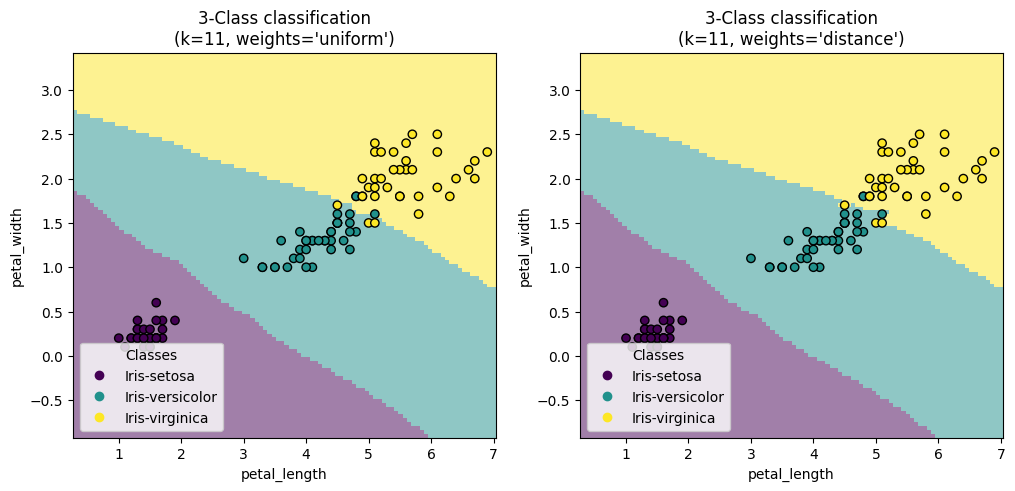

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["petal_length", "petal_width"]
X = df_cleaned[feature_columns]
y = df_cleaned["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Ubah nama kelas jadi angka

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

Akurasi: 0.8148148148148148
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.62      0.71      0.67         7
 Iris-virginica       0.71      0.62      0.67         8

       accuracy                           0.81        27
      macro avg       0.78      0.78      0.78        27
   weighted avg       0.82      0.81      0.81        27



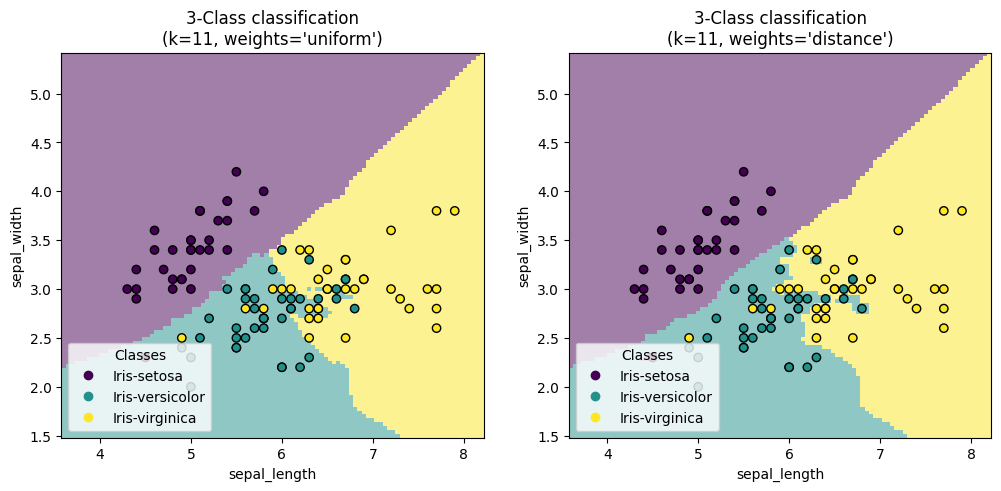

In [6]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay


# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["sepal_length", "sepal_width"]
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Mengubah nama kelas menjadi angka

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Menghapus data yang terdeteksi sebagai outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),  # Pastikan target dalam bentuk numerik
    test_size=0.2,
    random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()


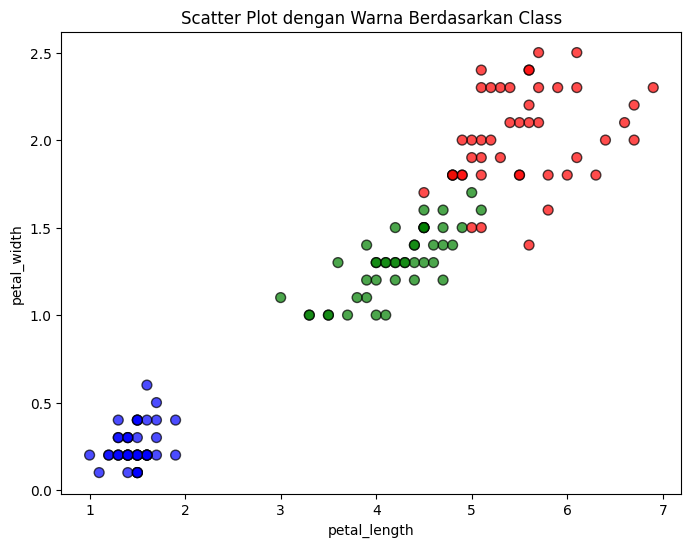

In [7]:
import matplotlib.pyplot as plt

# Pilih dua fitur untuk scatter plot
x_feature = "petal_length"
y_feature = "petal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "red"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()

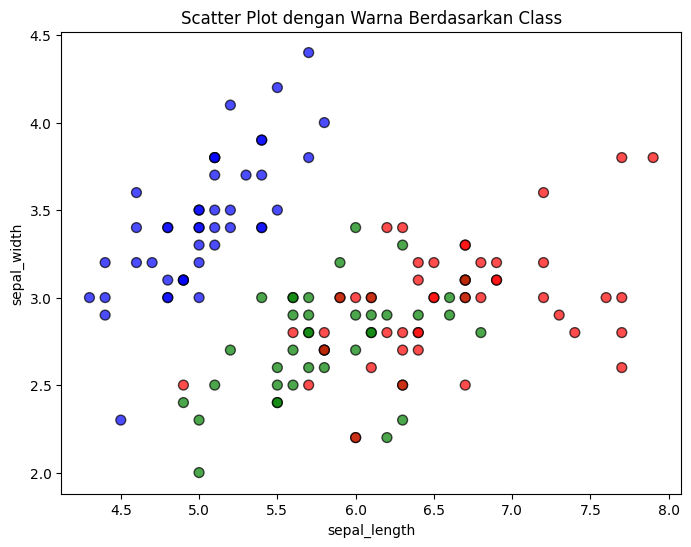

In [8]:
import matplotlib.pyplot as plt

# Pilih dua fitur untuk scatter plot
x_feature = "sepal_length"
y_feature = "sepal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "red"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()

## **Implementasi Naive Bayes pada Data**

Number of mislabeled points with outliers out of a total 30 points : 20
Accuracy with outliers: 33.33%
Mislabeled points with outliers:
Index: 1, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 2, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 5, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 7, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 10, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 11, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 12, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 13, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 14, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 19, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 20, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 21, True Label: Iris-virginica, Predicted: Iris-versicolor
Index: 22, True Label: Iris-setosa, Predicted: Iris-versicolor
Index: 23, True Label: Iris-virgin

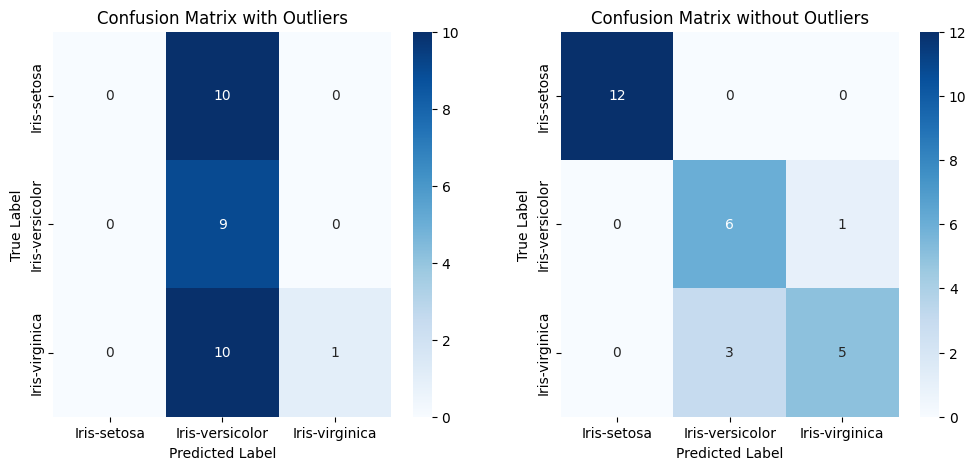

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsikan df_merged sudah ada dari kode sebelumnya

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
df_merged["class_encoded"] = label_encoder.fit_transform(df_merged["class"])

# Data dengan outlier
X_all = df_merged[feature_columns]
y_all = df_merged["class_encoded"].values  # Pastikan dalam bentuk array numpy

# Data tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])
X_clean = df_cleaned[feature_columns]
y_clean = df_cleaned["class_encoded"].values  # Pastikan dalam bentuk array numpy

# Split data dengan outlier
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42)

# Split data tanpa outlier
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42)

# Inisialisasi model Naive Bayes
gnb = GaussianNB()

# Latih dan uji model dengan outlier
y_pred_all = gnb.fit(X_train_all, y_train_all).predict(X_test_all)
mislabeled_all = (y_test_all != y_pred_all).sum()
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Number of mislabeled points with outliers out of a total %d points : %d" % (X_test_all.shape[0], mislabeled_all))
print("Accuracy with outliers: %.2f%%" % (accuracy_all * 100))

# Menampilkan label yang salah pada data dengan outlier
mislabeled_indices_all = np.where(y_test_all != y_pred_all)[0]
print("Mislabeled points with outliers:")
for i in mislabeled_indices_all:
    true_label = label_encoder.inverse_transform([int(y_test_all[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_all[i])])[0]
    print(f"Index: {i}, True Label: {true_label}, Predicted: {predicted_label}")
print()
# Latih dan uji model tanpa outlier
y_pred_clean = gnb.fit(X_train_clean, y_train_clean).predict(X_test_clean)
mislabeled_clean = (y_test_clean != y_pred_clean).sum()
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Number of mislabeled points without outliers out of a total %d points : %d" % (X_test_clean.shape[0], mislabeled_clean))
print("Accuracy without outliers: %.2f%%" % (accuracy_clean * 100))

# Menampilkan label yang salah pada data tanpa outlier
mislabeled_indices_clean = np.where(y_test_clean != y_pred_clean)[0]
print("Mislabeled points without outliers:")
for i in mislabeled_indices_clean:
    true_label = label_encoder.inverse_transform([int(y_test_clean[i])])[0]
    predicted_label = label_encoder.inverse_transform([int(y_pred_clean[i])])[0]
    print(f"Index: {i}, True Label: {true_label}, Predicted: {predicted_label}")

# Visualisasi Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test_all, y_pred_all), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix with Outliers")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(confusion_matrix(y_test_clean, y_pred_clean), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix without Outliers")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()